<a href="https://colab.research.google.com/github/BennoKrojer/CityClassifier/blob/master/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook is mostly copy-pasted and slightly adapted to my use-case from:
https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson2-download.ipynb

If you just want to play around with the already trained model, just run the cells in 'Setup' and then just expand 'Inference' to use the already trained model.

## Setup

In [39]:
  !curl -s https://course.fast.ai/setup/colab | bash
  !git clone https://github.com/BennoKrojer/CityClassifier.git

Updating fastai...
Done.
Cloning into 'CityClassifier'...
remote: Enumerating objects: 3911, done.
remote: Total 3911 (delta 0), reused 0 (delta 0), pack-reused 3911
Receiving objects: 100% (3911/3911), 126.41 MiB | 32.95 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [40]:
!ls
!pwd

CityClassifier	data  models
/content


In [0]:
import warnings
warnings.filterwarnings("ignore")

In [0]:
from fastai.vision import *

In [0]:
base_path = Path('./CityClassifier/')
data_path = base_path/'dataset'

In [59]:
data_path.ls()


[PosixPath('CityClassifier/dataset/rome_url.csv'),
 PosixPath('CityClassifier/dataset/moscow'),
 PosixPath('CityClassifier/dataset/paris'),
 PosixPath('CityClassifier/dataset/test'),
 PosixPath('CityClassifier/dataset/madrid'),
 PosixPath('CityClassifier/dataset/moscow_url.csv'),
 PosixPath('CityClassifier/dataset/lisboa_url.csv'),
 PosixPath('CityClassifier/dataset/london'),
 PosixPath('CityClassifier/dataset/paris_url.csv'),
 PosixPath('CityClassifier/dataset/berlin_url.csv'),
 PosixPath('CityClassifier/dataset/rome'),
 PosixPath('CityClassifier/dataset/berlin'),
 PosixPath('CityClassifier/dataset/london_url.csv'),
 PosixPath('CityClassifier/dataset/cleaned.csv'),
 PosixPath('CityClassifier/dataset/lisboa'),
 PosixPath('CityClassifier/dataset/madrid_url.csv')]

## View data

In [0]:
# Since I already cleaned the data, we will only load the clean images
np.random.seed(42)
data = ImageDataBunch.from_csv(data_path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [61]:
data.classes

['berlin', 'lisboa', 'london', 'madrid', 'moscow', 'paris', 'rome']

Good! Let's take a look at some of our pictures then.

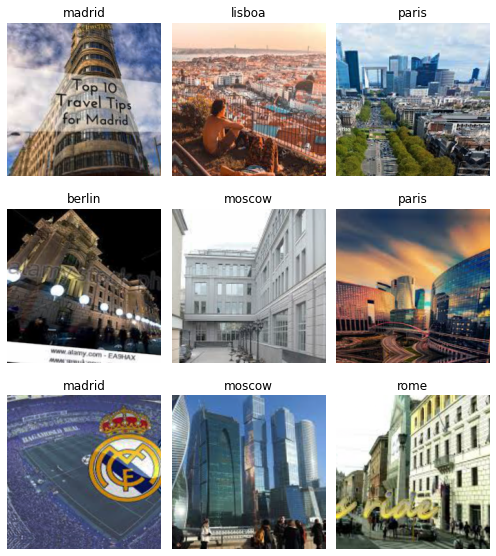

In [47]:
data.show_batch(rows=3, figsize=(7,8))

In [48]:
data.c, len(data.train_ds), len(data.valid_ds)

(7, 3066, 766)

## Train model

In [0]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [0]:
learn.fit_one_cycle(4)

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


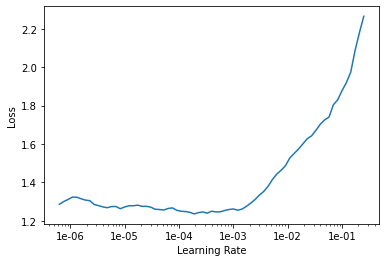

In [0]:
# If the plot is not showing try to give a start and end learning rate
# learn.lr_find(start_lr=1e-5, end_lr=1e-1)
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(8, max_lr=slice(3e-4,3e-3))

In [0]:
learn.save('stage-2')

## Interpretation

In [0]:
learn.load('stage-2')

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

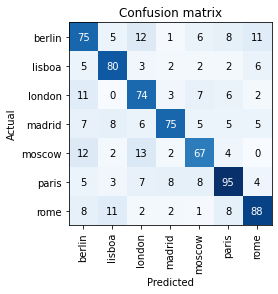

In [0]:
interp.plot_confusion_matrix()

## Cleaning Up

Some of our top losses aren't due to bad performance by our model. There are images in our data set that shouldn't be.

Using the `ImageCleaner` widget from `fastai.widgets` we can prune our top losses, removing photos that don't belong.

This has been already done and saved in cleaned.csv. But you can go for it again and maybe find more!

In [0]:
from fastai.widgets import *

In [0]:
# Here I only load the a set of hopefully already clean images
db = (ImageList.from_csv(path, 'cleaned.csv', folder='.')
                   .split_none()
                   .label_from_df()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Then we create a new learner to use our new databunch with all the images.

In [0]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)
learn_cln.load('stage-2')

In [0]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

Make sure you're running this notebook in Jupyter Notebook, not Jupyter Lab. That is accessible via [/tree](/tree), not [/lab](/lab). Running the `ImageCleaner` widget in Jupyter Lab is [not currently supported](https://github.com/fastai/fastai/issues/1539).

In [0]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Flag photos for deletion by clicking 'Delete'. Then click 'Next Batch' to delete flagged photos and keep the rest in that row. `ImageCleaner` will show you a new row of images until there are no more to show. In this case, the widget will show you images until there are none left from `top_losses.ImageCleaner(ds, idxs)`

You can also find duplicates in your dataset and delete them! To do this, you need to run `.from_similars` to get the potential duplicates' ids and then run `ImageCleaner` with `duplicates=True`. The API works in a similar way as with misclassified images: just choose the ones you want to delete and click 'Next Batch' until there are no more images left.

Make sure to recreate the databunch and `learn_cln` from the `cleaned.csv` file. Otherwise the file would be overwritten from scratch, losing all the results from cleaning the data from toplosses.

In [0]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [0]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

Remember to recreate your ImageDataBunch from your `cleaned.csv` to include the changes you made in your data!

In [0]:
data = ImageDataBunch.from_csv(path, folder=".", valid_pct=0.2, csv_labels='cleaned.csv',
ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

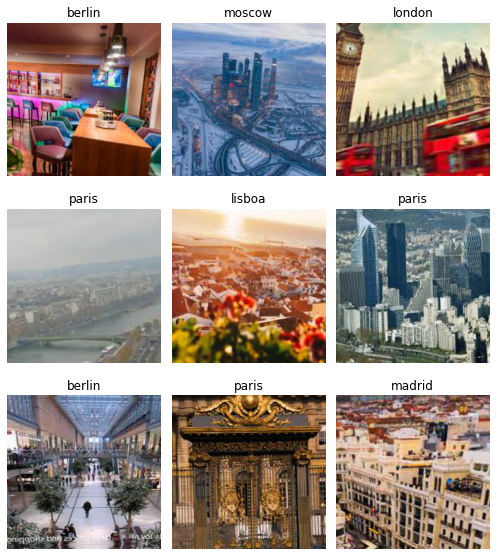

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['berlin', 'lisboa', 'london', 'madrid', 'moscow', 'paris', 'rome'],
 7,
 3066,
 766)

To finish up, let's export the content of our `Learner` object for production:

In [0]:
learn.export()

This will create a file named 'export.pkl' in the directory where we were working that contains everything we need to deploy our model (the model, the weights but also some metadata like the classes or the transforms/normalization used).

## Inference

You probably want to use CPU for inference, except at massive scale (and you almost certainly don't need to train in real-time). If you don't have a GPU that happens automatically. You can test your model on CPU like so:

In [0]:
defaults.device = torch.device('cpu')

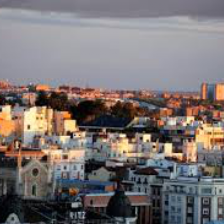

In [0]:
val_img = data.valid_ds[0][0]
groundtruth = data.valid_ds[0][1]
val_img

In [0]:
data.classes[int(groundtruth)]

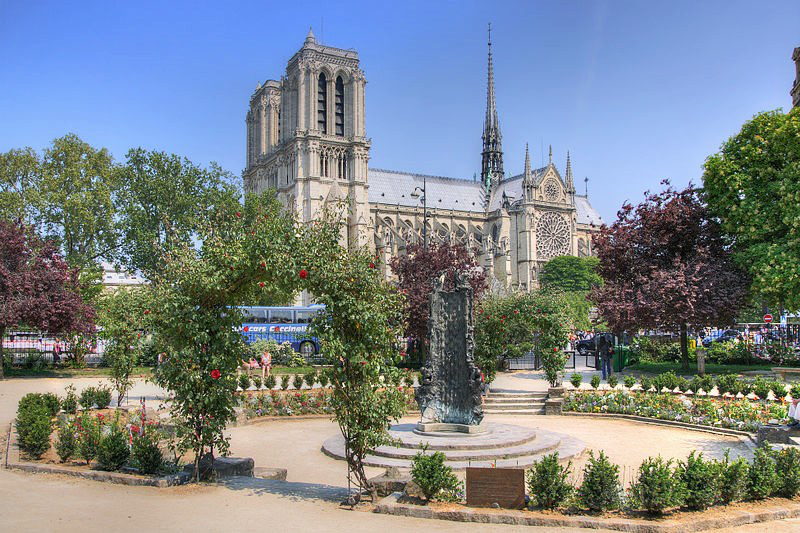

In [68]:
# here you can paste any URL you like.
# Just make sure that you didn't get the image by googling the city name only,
# because this would mean that the image was probably in the training data.
url = 'https://bonjourparis.com/wp-content/uploads/2017/08/Notre-Dame_de_Paris_-_Square_Ren%C3%A9_Viviani-Montebello_Paris_April_23_2011.jpg'
response = requests.get(url)
test_img = open_image(BytesIO(response.content))
test_img

We create our `Learner` in production enviromnent like this, just make sure that `path` contains the file 'export.pkl' from before.

In [0]:
learn = load_learner(base_path)

In [72]:
pred_class,pred_idx,outputs = learn.predict(test_img)
data.classes[int(pred_class)]

'paris'